In [495]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import os

DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [496]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return TensorDataset(X, Y)

In [497]:
def get_Cifar10_dl(batch_size_train=256, batch_size_eval=1024, device=DEVICE):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = CIFAR10('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [45000,5000])
    
    data_test = CIFAR10('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [498]:
def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [499]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [500]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()

In [501]:
#stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : []}
def print_stats_full(stats):

  fig, axs= plt.subplots(3, 2, figsize=(7,9), dpi=110)

  axs[0, 0].set_title("ERM loss")
  axs[0, 1].set_title("Valid Acc")
  axs[1, 0].set_title("diff mean")
  axs[1, 1].set_title("diff variance")
  axs[2, 0].set_title("cosine")
  axs[2, 1].set_title("scale_diff")
  #axs[2, 1].set_title("same_sign_perc")


  for i in range(3):
    for j in range(2):
      axs[i, j].set_xlabel("iterations")
      axs[i, j].grid()
  
  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  axs[0, 0].set_ylim(0.0, max(loss))
  axs[0, 0].plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  axs[0, 1].set_ylim(0.0, 1.05)
  axs[0, 1].plot(itrs, acc)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_mean = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 0].set_ylim(min(diff_mean), max(diff_mean))
  axs[1, 0].plot(itrs, diff_mean)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_variance = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 1].set_ylim(0.0, max(diff_variance))
  axs[1, 1].plot(itrs, diff_variance)

  itrs = [x[0] for x in stats['cosine']]
  cosine = [x[1].cpu() for x in stats['cosine']]
  axs[2, 0].set_ylim(min(cosine), max(cosine))
  axs[2, 0].plot(itrs, cosine)

  
  itrs = [x[0] for x in stats['scale_diff']]
  scale_diff = [x[1].cpu() for x in stats['scale_diff']]
  axs[2, 1].set_ylim(min(scale_diff), max(scale_diff))
  axs[2, 1].plot(itrs, scale_diff)
  '''
  itrs = [x[0] for x in stats['same_sign_perc']]
  scale_diff = [x[1].cpu() for x in stats['same_sign_perc']]
  axs[2, 1].set_ylim(0, 1)
  axs[2, 1].plot(itrs, scale_diff)
  '''
  plt.tight_layout()
  fig.savefig('testing.jpg', bbox_inches = 'tight')
  print(np.median(cosine))

In [502]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, max(loss))
  ax2.set_ylim(0.0, 1.05)
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [503]:
def print_corrcoef_heatmap(matrix):
    a = torch.corrcoef(matrix)
    print(torch.mean(torch.abs(a)))
    print(torch.median(torch.abs(a)))
    sns.heatmap(a.to('cpu'))
    

In [504]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(4*4*512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [505]:
class Batch_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Batch_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [506]:
def cal_proj_matrix(A):
    return A @ torch.linalg.pinv(A.T @ A) @ A.T

In [507]:
def run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_linear_projection, version, print_corrcoef, target_itr, target_layer):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : [], 'same_sign_perc' : []}

    if use_forward_grad:
        random_dir = {}
        for i, p in enumerate(model.parameters()):
            random_dir[i] = 0

    if use_linear_projection:
        name_module = {}
        layer_inputs = {}
        def hook(mod, input):
            layer_inputs[mod] = input[0]
        for module in model.modules():
            module.register_forward_pre_hook(hook)
        for name, module in model.named_modules():
            name_module[name] = module
    
    for epoch in range(max_epochs):
        for x, y in train_dl:
            #print(itr)
            itr += 1
            opt.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()

            if print_corrcoef:
                if target_itr == itr:
                    cur_layer = -1
                    for i, (name, parameters) in enumerate(model.named_parameters()):
                        if len(parameters.shape) == 2:
                            cur_layer += 1
                            if cur_layer == target_layer:
                                g = parameters.grad
                                print_corrcoef_heatmap(g)
                                break

            if print_corrcoef and target_itr == itr:
                return stats
            
            if print_corrcoef == False and use_forward_grad == True:
                with torch.no_grad():
                    da = torch.zeros((num_dir, 1), device = DEVICE)

                    for i, (name, parameters) in enumerate(model.named_parameters()):
                        g = parameters.grad.view(-1)

                        if len(parameters.shape) == 2 and use_linear_projection:
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]]

                            #Random rank-1 estimation
                            if version == 0:
                                input_sample = torch.randn(num_dir, 1, parameters.shape[1], device = DEVICE)
                                v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                                v = (v @ input_sample).view(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)

                            #Rank-1 estimation, but the row space lies in the subspace spanned by the input matrix
                            elif version == 1:
                                projection_matrix = cal_proj_matrix(input.T)
                                input_sample = torch.randn(num_dir, parameters.shape[1], device = DEVICE).view(num_dir, parameters.shape[1], 1)
                                input_sample = (projection_matrix @ input_sample).view(num_dir, 1, -1)
                                v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                                v = (v @ input_sample).view(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            
                            #Estimaion of rank B (in most cases), each row lies in the subspace spanned by the input matrix
                            elif version == 2:
                                v = torch.randn(num_dir, input.shape[0], parameters.shape[0], device = DEVICE)
                                v = (torch.transpose(v, 1, 2) @ input)
                                v = v.reshape(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            
                            #Should be the same as version 2, it's just istead of random linear combination, we do projection of a random matrix (maybe this can give a better scale)
                            elif version == 3:
                                projection_matrix = cal_proj_matrix(input.T)
                                v = torch.randn(num_dir, parameters.shape[1], parameters.shape[0], device = DEVICE)
                                v = projection_matrix @ v
                                v = torch.transpose(v, 1, 2).reshape(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            
                            #This maybe the same as version 1
                            elif version == 4:
                                projection_matrix = cal_proj_matrix(input.T)
                                input_sample = torch.randn(num_dir, parameters.shape[1], device = DEVICE).view(num_dir, parameters.shape[1], 1)
                                input_sample = projection_matrix @ input_sample.repeat(1, 1, input.shape[0])
                                v = torch.randn(num_dir, input.shape[0], parameters.shape[0], device = DEVICE)
                                v = (input_sample @ v)
                                v = torch.transpose(v, 1, 2)
                                v = v.reshape(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            
                        else:
                            v = torch.randn(num_dir, len(g), device=DEVICE)
                        
                        random_dir[i] = v
                        da += (v @ g).view(num_dir, 1)

                    estimation = torch.tensor([]).to(DEVICE)
                    true_gradient = torch.tensor([]).to(DEVICE)
                    for i, p in enumerate(model.parameters()):
                        g = da * random_dir[i]
                        true_gradient = torch.cat((true_gradient, p.grad.view(-1)), dim = 0)
                        estimation = torch.cat((estimation, torch.mean(g, dim = 0)), dim = 0)
                        p.grad = torch.mean(g, dim = 0).view(p.grad.shape)
            
                        

            opt.step()
            scheduler.step()
            stats['train-loss'].append((itr, loss.item()))

            if use_forward_grad:
                same_sign_perc = torch.sum(true_gradient.sign() == estimation.sign())/torch.numel(true_gradient)
                scale_true_gradient = true_gradient.norm()
                scale_estimation = estimation.norm()
                stats['diff_mean'].append((itr, torch.mean(estimation - true_gradient)))
                stats['diff_variance'].append((itr, torch.var(estimation - true_gradient)))
                stats['cosine'].append((itr, torch.sum(true_gradient*estimation)/(scale_true_gradient*scale_estimation)))
                stats['scale_diff'].append((itr, scale_estimation - scale_true_gradient))
                stats['same_sign_perc'].append((itr, same_sign_perc))
            
            if itr % 100 == 0:
                #print(same_sign_perc)
                valid_acc = get_acc(model, valid_dl)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)
    

    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")

    return stats



In [508]:
model= VGG16().to(DEVICE)
#model = Batch_CNN().to(DEVICE)
#model = CNN().to(DEVICE)
#model = small_CNN().to(DEVICE)
#model = LeNet().to(DEVICE)
print(count_parameters(model))

train_batch_size = 128
test_batch_size = 1024

#train_dl, valid_dl, test_dl = get_mnist_dl(train_batch_size, test_batch_size, device = DEVICE)
train_dl, valid_dl, test_dl = get_Cifar10_dl(train_batch_size, test_batch_size, device = DEVICE)
opt = torch.optim.SGD(model.parameters(), lr = 1e-4)
#opt = torch.optim.Adam(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)
criterion =nn.CrossEntropyLoss()
max_epochs = 20

use_forward_grad = True
num_dir = 10
use_linear_projection = True
version = 1
print_corrcoef = False
target_itr = 3500
target_layer = 2

13424202
Files already downloaded and verified
Files already downloaded and verified


0:0 [train] loss:2.354, [valid] acc:0.094
0:100 [train] loss:2.204, [valid] acc:0.187
0:200 [train] loss:2.127, [valid] acc:0.198
0:300 [train] loss:2.141, [valid] acc:0.224
1:400 [train] loss:2.033, [valid] acc:0.222
1:500 [train] loss:2.107, [valid] acc:0.243
1:600 [train] loss:1.985, [valid] acc:0.258
1:700 [train] loss:1.998, [valid] acc:0.265
2:800 [train] loss:1.998, [valid] acc:0.282
2:900 [train] loss:1.951, [valid] acc:0.286
2:1000 [train] loss:1.885, [valid] acc:0.285
3:1100 [train] loss:1.884, [valid] acc:0.294
3:1200 [train] loss:2.035, [valid] acc:0.293
3:1300 [train] loss:2.073, [valid] acc:0.282
3:1400 [train] loss:1.985, [valid] acc:0.307
4:1500 [train] loss:1.851, [valid] acc:0.295
4:1600 [train] loss:1.858, [valid] acc:0.311
4:1700 [train] loss:1.838, [valid] acc:0.306
5:1800 [train] loss:1.891, [valid] acc:0.308
5:1900 [train] loss:1.843, [valid] acc:0.306
5:2000 [train] loss:1.963, [valid] acc:0.316
5:2100 [train] loss:1.855, [valid] acc:0.323
6:2200 [train] loss:1.

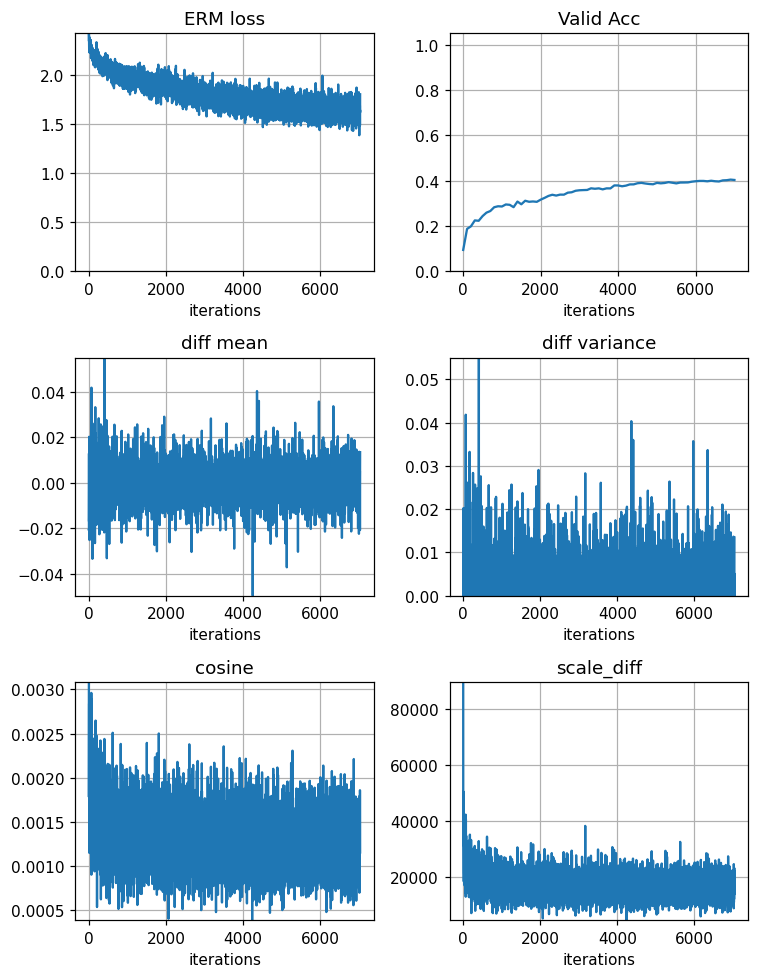

In [509]:
stats = run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_linear_projection, version, print_corrcoef, target_itr, target_layer)
if use_forward_grad == True and print_corrcoef == False:
    print_stats_full(stats)
elif print_corrcoef == False:
    print_stats(stats)

tensor(0.0259, device='cuda:0')
tensor(0.0211, device='cuda:0')


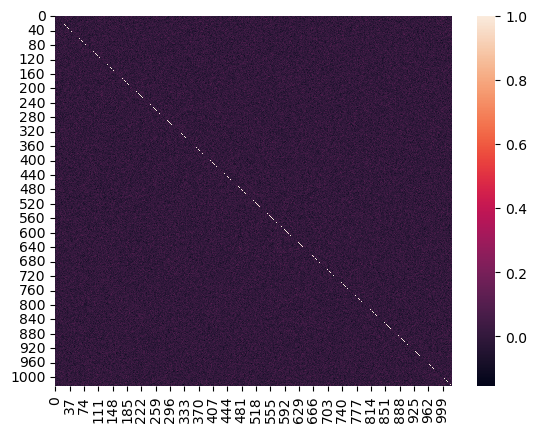

In [510]:
a = torch.randn(1024, 1024, device = DEVICE)
print_corrcoef_heatmap(a)